# Unified Super-Resolution Demo
Use this notebook to easily super-resolve your own images.

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from src.models.unified_model import UnifiedSRModel
from inference import forward_chop
import os

# 1. Settings
MODEL_PATH = 'checkpoints/model_final.pth'
IMAGE_PATH = 'data/medical/val/lr/Screenshot 2025-11-30 043925.png' # <--- CHANGE THIS TO YOUR IMAGE PATH
DOMAIN = 'medical' # 'medical', 'satellite', or None (Auto-detect)
SCALE = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# 2. Load Model
model = UnifiedSRModel(upscale=SCALE).to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Model loaded successfully!")
else:
    print(f"Error: Model not found at {MODEL_PATH}")

Model loaded successfully!


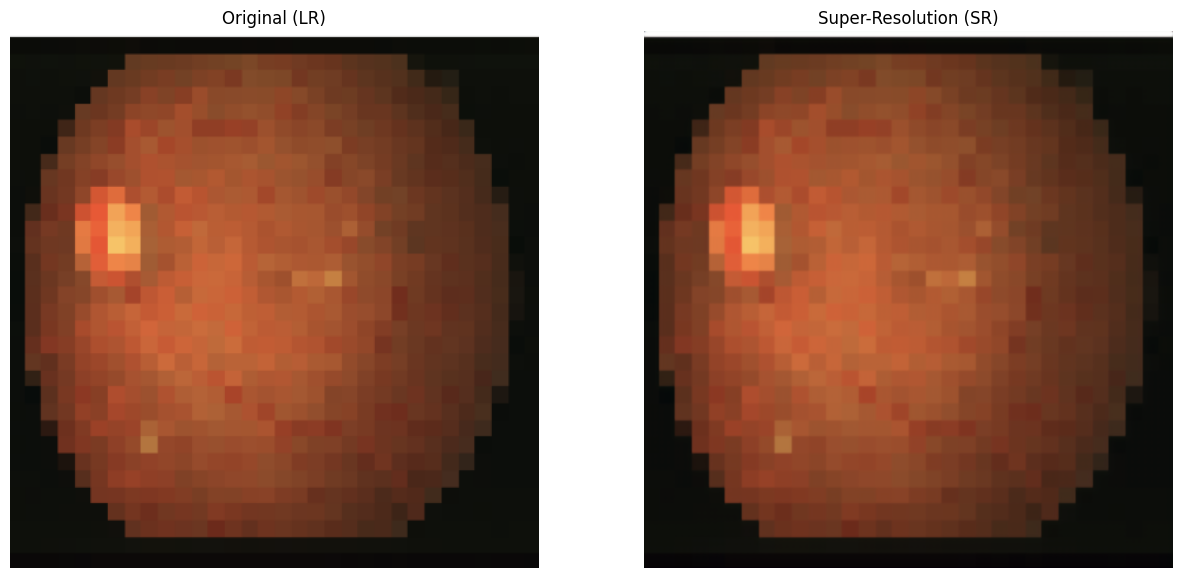

Saved result to output_sr.png


In [3]:
# 3. Run Inference
if os.path.exists(IMAGE_PATH):
    # Read Image
    img = cv2.imread(IMAGE_PATH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Preprocess
    lr_tensor = torch.from_numpy(img.transpose((2, 0, 1))).float() / 255.0
    lr_tensor = lr_tensor.unsqueeze(0).to(DEVICE)
    
    # Inference (using forward_chop to save memory)
    with torch.no_grad():
        # min_size=10000 ensures small patches for CPU memory safety
        sr_tensor, domain_logits = forward_chop(model, lr_tensor, DOMAIN, scale=SCALE, min_size=10000)
        
        # Check detected domain
        if DOMAIN is None:
            pred_idx = torch.argmax(domain_logits, dim=1).item()
            detected = 'Medical' if pred_idx == 0 else 'Satellite'
            print(f"Auto-detected Domain: {detected}")
    
    # Postprocess
    sr_img = sr_tensor.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    sr_img = np.clip(sr_img, 0, 1)
    
    # Visualize
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.title("Original (LR)")
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Super-Resolution (SR)")
    plt.imshow(sr_img)
    plt.axis('off')
    
    plt.show()
    
    # Save (Optional)
    save_path = 'output_sr.png'
    sr_bgr = cv2.cvtColor((sr_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, sr_bgr)
    print(f"Saved result to {save_path}")
    
else:
    print(f"Image not found at {IMAGE_PATH}")